# CS 271 Word2vec

In [1]:
# Define imports
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from numpy import asarray
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
import gensim.downloader as api
import matplotlib.pyplot as plt
import sys
import pickle
import os
import csv
from collections import defaultdict
import time
#
import re

### Step 1: Read in relevant Data Files

Make sure the files below are in the same directory as your jupyter file

In [2]:
# Define constants
PATIENT_DATA_FILE = 'B220_SAA_v1.csv'
CLEANED_LABELS_FILE = 'ICD_Label_Cleaned_Oct_25.csv'
CODE_DESC_FILE = 'BIODS220_ICD_Dx_10_9_v7 - icd_dx_10_9_v7.csv'
# May want to consider: glove-wiki-gigaword-100 in the future
# See more here: https://github.com/RaRe-Technologies/gensim-data
LANG_MODEL = 'word2vec-google-news-300'

In [3]:
def read_csv_to_dict(file_path: str, key: int, value: int):
    ret_dict = {}
    with open(file_path, newline='') as csvfile:
        data = csv.reader(csvfile, delimiter=',')
        for row in data:
            ret_dict[row[key]] = row[value]
    print("Reading {} complete!".format(file_path))
    return ret_dict

In [4]:
def get_category_dict():
    category_dict = {
        'Circulatory': 0,
        'Dermatologic': 4,
        'Endocrine & Immune': 6,
        'Gastrointestinal': 1,
        'Genitourinary': 1, 
        'Hematologic': 4,
        'Infectious': 6,
        'Injury': 2,
        'Injury & Poisoning': 2,
        'Poisoning': 2,
        'Musculoskeletal': 2,
        'Neurologic': 3,
        'Other': 4,
        'Obstetric': 5,
        'Neoplastic': 4,
        'Psychiatric': 3,
        'Respiratory': 0,
        'Substance use': 2}
    #use to_categorical()
    return category_dict

In [5]:
NUM_CLASSES = 7

In [6]:
def get_label2className_dict():
    '''
    Function to create reverse map of labels to category name
    '''
    category_dict = {
        0:'Cardio-Resp',
        1:'Abdominal',
        2:'Injury/Subst/Poison', 
        3:'NeuroPsych',
        4:'Other',
        5:'Obstetric',
        6:'Infection-Immune'
    }
    #use to_categorical()
    return category_dict

In [7]:
# Import word to vec model - takes a few minutes
wv = api.load(LANG_MODEL)
print("Reading {} complete!".format(LANG_MODEL))

# Create labels dict i.e. code -> label, i.e. A840 -> 'Neurologic'
label_dict = read_csv_to_dict(CLEANED_LABELS_FILE, key=0, value=1)

# Create descriptions dict i.e. code -> description
codes_dict = read_csv_to_dict(CODE_DESC_FILE, key=0, value=2)

# Create dict for label to int
category_dict = get_category_dict()

Reading word2vec-google-news-300 complete!
Reading ICD_Label_Cleaned_Oct_25.csv complete!
Reading BIODS220_ICD_Dx_10_9_v7 - icd_dx_10_9_v7.csv complete!


### Step 2: Create one-hot feature vectors

For the sake of reducing feature space, we are only including three features in our embedding. Future iterations of our embeddings will include more features, such as the patient's county.

In [8]:
def create_one_hot(patient_data):
    # Creates one-hot vectors
    columns_to_one_hot = ['Sex','Race']
    one_hot = pd.get_dummies(patient_data[columns_to_one_hot])
    
    ordinal_columns = ['Age']
    one_hot = pd.concat([patient_data[ordinal_columns], one_hot], axis=1)
    
    # Normalize age
    x = one_hot.Age.values.reshape(-1,1)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    one_hot.Age = x_scaled
    
    return one_hot.values

In [9]:
# Read in patient_data - takes a few mins
patient_read_start = time.time()
patient_data = pd.read_csv(PATIENT_DATA_FILE, dtype=str, usecols=['Sex','Race','Age','Dx10_prin'])
print("Reading in patient_data took {}".format(time.time() - patient_read_start))

# One-hot encode visit features
one_hot_start = time.time()
one_hot = create_one_hot(patient_data)
print("Creating one-hot encodings took {}".format(time.time() - one_hot_start))
print(one_hot.shape)

Reading in patient_data took 40.31721591949463
Creating one-hot encodings took 10.295305252075195
(27977932, 11)


In [10]:
# (num_patients, 311)

# Step 3: Embed ICD Codes + concat with one-hot vectors

Given a sentence, retrieve the pre-trained word2vec embedding for each word in the sentence and return the mean of the embeddings. If the sentence has no words that exist in the word2vec model, we return None.

In [11]:
def embed_sentence(sentence, split_tokens): 
    # Revisit: since medical terms may not be present, although they are important to include
    word_embeddings = []
    for word in re.split(split_tokens, sentence):
        try:
            word_embeddings.append(wv[word.lower()])
        except KeyError:
            continue
    if len(word_embeddings)>0:
        return np.mean(word_embeddings, axis=0)
    else:
        return None

Given a sentence and label, return the embedding of a sentence. If there is no embedding for the sentence then return the embedding for the label.

In [12]:
def get_w2v_embedding(sentence, label):
    """
    Sentence: A description of an ICD10 code, usually 1-5 words
    Category: The class of the diagnosis, one of 17 options
    """
    embedding = embed_sentence(sentence, split_tokens='\s|(?<!\d)[:;,.\(\)\[\]-](?!\d)')
    
    # If we can't create embedding with ICD10 codes, we use category
    if embedding is not None:
        return embedding
    else:
        return embed_sentence(label, split_tokens='\s')

Given an ICD code, return the corresponding description. Here, we attempt to take handle mistyped data. Some codes are missing 1-2 characters. Sometimes, adding a 0 or removing the last character in a code will fix typos, however this strategy is prone to error and not guarunteed to work.

In [13]:
def get_desc(code):
    try:
        desc = codes_dict[code]
    except KeyError:
        try:
            new_code = code + '0'
            desc = codes_dict[new_code]
        except:
            try:
                new_code = code[:-1]
                desc = codes_dict[new_code]
            except:
                desc = 'Other'
    try:
        label = labels_dict[code]
    except:
        label = 'Other'
    return desc, label

Given an ICD code, we retrieve the embedding (300x1). We use dynamic programming to save embeddings. Often, only the first three characters of an ICD code are enough to determine the general diagnosis. Longer codes will only have slightly different descriptions (if at all). Thus, to reduce computational complexity, we store the first three characters of ICD codes. Future ICD codes that share the same first three characters will automatically use the same embedding, regardless of any remaining characters.

In [14]:
descriptions_dict = {}

def code_to_embedding(code):
    try:
        embedding = descriptions_dict[str(code[:3])]
    except:
        desc, category = get_desc(code)
        embedding = get_w2v_embedding(desc, category)
        if desc is not 'Other':
            descriptions_dict[str(code[:3])] = embedding
    return embedding

For each row of ICD Codes (i.e ['E839', 'SA920']), we retrieve the corresponding embeddings. For patient visits with n ICD Codes where n>1, we give 0.75 weight to the primary ICD code and 0.25/n-1 weight to the remaining (secondary) codes.

In [15]:
PRIMARY_WEIGHT = 0.5
SECONDARY_WEIGHT = 0.5

def row_to_embedding(input_row):
    """
    input_row: A list of ICD10 codes
    returns a 300x1 embedding
    """
    n = len(input_row)
    code = input_row[0]
    # Primary ICD code:
    primary_embedding = code_to_embedding(code)
    if n < 2: return primary_embedding
    
    # Subsequent ICD codes:
    secondary_embedding = None
    for i in range(1, n):
        code = input_row[i]
        curr_embed = code_to_embedding(code)
        if secondary_embedding is None:
            secondary_embedding = curr_embed
        else:
            secondary_embedding = np.sum([secondary_embedding, curr_embed], axis=0)
    
    
    return np.sum([primary_embedding * PRIMARY_WEIGHT, secondary_embedding * (SECONDARY_WEIGHT/n-1)], axis=0)


We read in the patient visit csv file again and create embeddings for each visit as we read the file. For each visit, we have already computed the one-hot vector encoding for categorical and ordinal variables. Here, we combine those encodings with ICD_10 code embeddings. To reduce model complexity, we limit the number of patients (not total visits) for which to create embeddings. Here, we are working under the assumption that all visits for a patient appear one after the other in the csv file, thus, we can stop reading from the file once `patient id > num_patients`. Takes a few mins to run

In [16]:
NUM_PATIENTS = .2e6

def get_visit_embedding(input_file_path: str):
    start_time = time.time()
    embeddings = []
    patient_visit = []
    max_len = 0
#     patient_visit = {
#         1 : [[1, embed],[4, embed],[2,embed]],
#         2 : [[embed],[embed],....],
#         .
#         .
#         .
#     }
    with open(input_file_path, newline='') as csvfile:
        data = csv.reader(csvfile, delimiter=',')
        count = 0
        for row in data: # <- top to bottom
            if count == 0: # Skip the first row
                count += 1
                continue
            
            if int(row[0]) > NUM_PATIENTS: # Used to limit num patients, reducing model space
                break
                
            ICD_code_embeddings = row_to_embedding([entry for entry in row[16:41] if entry is not ''])
            
            # Combine one-hot with w2v embeddings
            visit_embedding = np.concatenate((one_hot[count-1, :], ICD_code_embeddings), axis=0)
            embeddings.append(visit_embedding)
            patient_visit.append([row[0], row[1]]) # store patient and visit info
            
            # Tracking progress
            if count % 250000 == 0:
                print("Completed {} visit embeddings in {}".format(count, (time.time() - start_time)))
            count +=1
            
    print("Shape of embeddings: ({},{})".format(len(embeddings), len(embeddings[0])))
    print("Shape of patient_visit: ({},{})".format(len(patient_visit), len(patient_visit[0])))
    embedding_vecs = np.array(embeddings)
    result = np.hstack((np.array(patient_visit),embedding_vecs)) # patient id, visit id, embedding vector
    return result, count-1

embedding_dset, num_visits = get_visit_embedding(PATIENT_DATA_FILE)

Completed 250000 visit embeddings in 21.50507402420044
Shape of embeddings: (428174,311)
Shape of patient_visit: (428174,2)


### Step 4: Get labels

To create labels, we copy the primary diagnosis codes (`DX10_prin` column) into its own column named `Label`. For each code, we use the `label_dict` to retrive the corresponding category of the ICD code. Then we use the `category_dict` to retieve a number to represent the label. We limit the number of visits to the same size as the number of embeddings.

In [17]:
def convert_Dx10_prin_to_label(DX_10_code):
    try:
        category = label_dict[DX_10_code] # i.e. A065 -> Infectious
    except KeyError:
        category = 'Other'
    return category_dict[category] # i.e. Infectious -> 7 

def get_y_labels(patient_data):
    # Copy Dx10 code into new column named Label
    patient_data['Label'] = patient_data.Dx10_prin

    # Apply function to Label column to convert Dx10_prin code to category
    patient_data.Label = patient_data.Label.apply(convert_Dx10_prin_to_label)
    
    # Saves only the top num_visits, since that's how many embeddings there are
    y_list = patient_data.Label.iloc[:num_visits].to_list()
    return np.array(y_list), len(y_list)

In [18]:
# Get y_dset
label_start = time.time()
y_dset, num_labels = get_y_labels(patient_data)
print("Creating labels took {}".format(time.time() - label_start))

Creating labels took 14.669004201889038


In [19]:
# Ensures the number of labels corresponds to the number of patient visits
assert(num_labels == num_visits)

### Step 5: Save embeddings and labels

In [20]:
filename = 'embeddings_{}.pickle'.format(LANG_MODEL)

start_time = time.time()
pickle_out = open(filename, 'wb')
pickle.dump((embedding_dset, y_dset), pickle_out, protocol=4)
pickle_out.close()
print("Saving embeddings took: {}".format(time.time() - start_time))

Saving embeddings took: 161.7739441394806


In [21]:
# filename = 'embeddings_{}.pickle'.format(LANG_MODEL)
# start_time = time.time()
# pickle_in = open(filename, 'rb')
# embedding_dset, y_dset = pickle.load(pickle_in)
# pickle_in.close()
# print("Saving embeddings took: {}".format(time.time() - start_time))

### Step 6: Store patient_id, visit_id, embedding_vec, label in a pandas dataframe

In [22]:
collated_data = np.hstack((embedding_dset, y_dset.reshape(y_dset.shape[0],1))) # -- last col is label column, first 2 are patient an visit ids
cols =  ['patient_id', 'visit_id'] + ['embed_vec'+ str(i) for i in range(embedding_dset.shape[1]-2)] + ['label']
df = pd.DataFrame(data = collated_data, columns = cols)

Transform the data types 

In [23]:
df['patient_id'] = df['patient_id'].astype(str).astype('int64')
df['visit_id'] = df['visit_id'].astype(str).astype('int64')
for col in cols[2:-1]:
    df[col] = df[col].astype(str).astype(np.float32)

df['label'] = df['label'].astype(str).astype(np.int16)

In [24]:
df.dtypes

patient_id        int64
visit_id          int64
embed_vec0      float32
embed_vec1      float32
embed_vec2      float32
                 ...   
embed_vec307    float32
embed_vec308    float32
embed_vec309    float32
embed_vec310    float32
label             int16
Length: 314, dtype: object

Comment out the pickle dump/load sections below based on need

In [25]:
filename = 'patient_dataframe.pkl'
pickle_out = open(filename, 'wb')
pickle.dump(df, pickle_out, protocol=4)
pickle_out.close()

In [26]:
# filename = 'patient_dataframe.pkl'
# pickle_in = open(filename, 'rb')
# df = pickle.load(pickle_in)
# pickle_in.close()

In [27]:
df.head()

,patient_id,visit_id,embed_vec0,embed_vec1,embed_vec2,embed_vec3,embed_vec4,embed_vec5,embed_vec6,embed_vec7,...,embed_vec302,embed_vec303,embed_vec304,embed_vec305,embed_vec306,embed_vec307,embed_vec308,embed_vec309,embed_vec310,label
0,1,1,0.296610,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.071838,-0.040487,0.097351,-0.018901,-0.061564,-0.119311,-0.006877,0.108238,-0.066976,2
1,1,2,0.305085,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.031657,0.136739,-0.124715,-0.038696,0.236018,-0.081909,0.068095,0.050334,0.190104,1
2,1,3,0.305085,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.032214,0.071410,0.032794,-0.103791,-0.057184,0.170422,-0.018829,-0.021997,-0.048975,2
3,1,4,0.313559,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.052081,-0.043798,0.228811,0.196742,0.071073,-0.018641,-0.257189,-0.131737,-0.015015,4
4,2,1,0.355932,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.018087,-0.052994,0.001587,0.053269,0.117310,-0.172607,-0.056071,0.037923,0.062826,1


### Step 7: Data preprocessing: Create triplets of visits with labels using Sliding window approach

In [28]:
print("Number of patients: ", len(df['patient_id'].unique()))

Number of patients:  68212


In [29]:
# DATA PROCESSING
# RESHAPE INPUT TO THE DESIRED FORM FOR LSTM TRAINING:
# NEED 3D tensors of shape: [n_samples, n_timesteps = 2, n_features = input vector dim]

In [30]:
df = df.sort_values(['patient_id', 'visit_id'])
gf = df.groupby('patient_id')
data_X = []
data_Y = []
for patient in df['patient_id'].unique():
#     print(patient)
    curr_patient = gf.get_group(patient)
    num_visits  = curr_patient.shape[0]
    if num_visits < 3:
        continue
    elif num_visits == 3:
        visit_0 = list(curr_patient.iloc[0,2:-1].values)
        visit_1 = list(curr_patient.iloc[1,2:-1].values)
        data_X.append([visit_0, visit_1])
        data_Y.append(curr_patient.iloc[2,-1])
    else:
        for i in range(0, num_visits-2):
            visit_0 = list(curr_patient.iloc[i,2:-1].values)
            visit_1 = list(curr_patient.iloc[i+1,2:-1].values)
            data_X.append([visit_0, visit_1])
            data_Y.append(curr_patient.iloc[i+2,-1])

In [31]:
data_X = np.array(data_X)

In [32]:
data_Y = np.asarray(data_Y)

In [33]:
print(data_X.shape, data_Y.shape)
print(data_Y[100])

(291750, 2, 311) (291750,)
1


In [34]:
filename = 'data_X_data_Y.pkl'
pickle_out = open(filename, 'wb')
pickle.dump((data_X, data_Y), pickle_out, protocol=4)
pickle_out.close()

In [35]:
# filename = 'data_X_data_Y.pkl'
# pickle_in = open(filename, 'rb')
# data_X, data_Y = pickle.load(pickle_in)
# pickle_in.close()

### Step 8: Shuffle the data with correspoding labels and create train-val-test splits

- All examples are shuffled within a class. For training, intra- and inter-class shuffling happens and for val and test, no inter-class shuffling. 
-  Class balance is enforced for train,. val, test sets; Downside of the below approach for enforcing class balance is that not all examples are used and the bottleneck is the class which has the loweest fraction of the total examples

In [36]:
category_examples = []
for i in range(NUM_CLASSES):
#     print(i)
    category_examples.append(sum(data_Y==i))
for i, num in enumerate(category_examples):
    print(i , " : ", num)

0  :  54301
1  :  57093
2  :  65160
3  :  42522
4  :  37891
5  :  11851
6  :  22932


In [37]:
min_category_size = np.floor(min(category_examples))
min_train_classSize = int(0.95*min_category_size)
min_val_classSize = int(0.025*min_category_size)
total_examples  =  sum(category_examples)
print(min_train_classSize)

11258


In [38]:
# dictionary mapping class label to all its examples
examples = defaultdict(list)
for i in range(data_Y.shape[0]): 
    examples[data_Y[i]].append(data_X[i,:,:])
    
# shuffle examples of each class in place in the dictionary
for i in range(NUM_CLASSES):
    random.shuffle(examples[i]) 

In [39]:
# select min number of examples for the train set, val set and test set

train_X = examples[0][:min_train_classSize]
train_y = [0]*min_train_classSize
for i in range(1,NUM_CLASSES):
    train_X = np.vstack((train_X, examples[i][:min_train_classSize]))
    train_y+=[i]*min_train_classSize
train_X = np.array(train_X)
train_y = np.asarray(train_y)

val_X = examples[0][min_train_classSize:min_train_classSize + min_val_classSize]
val_y = [0]*min_val_classSize
for i in range(1,NUM_CLASSES):
    val_X = np.vstack((val_X, examples[i][min_train_classSize:min_train_classSize + min_val_classSize]))
    val_y+=[i]*min_val_classSize
val_X = np.array(val_X)
val_y = np.asarray(val_y)

test_X = examples[0][min_train_classSize + min_val_classSize : min_train_classSize + 2*min_val_classSize]
test_y = [0]*len(test_X)
for i in range(1,NUM_CLASSES):
    test_examples = examples[i][min_train_classSize + min_val_classSize : min_train_classSize + 2*min_val_classSize]
    test_X = np.vstack((test_X, test_examples))
    test_y+=[i]*len(test_examples)
test_X = np.array(test_X)
test_y = np.asarray(test_y)

In [40]:
print(train_X.shape, train_y.shape)
print(val_X.shape, val_y.shape)
print(test_X.shape, test_y.shape)

(78806, 2, 311) (78806,)
(2072, 2, 311) (2072,)
(2072, 2, 311) (2072,)


Convert integer y labels to one-hot vectors

In [41]:
train_y = tf.keras.utils.to_categorical(train_y, num_classes=NUM_CLASSES)
val_y = tf.keras.utils.to_categorical(val_y, num_classes=NUM_CLASSES)
test_y = tf.keras.utils.to_categorical(test_y, num_classes=NUM_CLASSES)

print(train_X.shape, train_y.shape)
print(val_X.shape, val_y.shape)
print(test_X.shape, test_y.shape)


(78806, 2, 311) (78806, 7)
(2072, 2, 311) (2072, 7)
(2072, 2, 311) (2072, 7)


### Step 9: Create the model

In [45]:
BATCH_SIZE = 64
EPOCHS = 20
NUM_LSTM_UNITS = 50

In [46]:
# BUILD THE MODEL BY ADDING LAYERS
model = tf.keras.models.Sequential()

# add a bidirectional LSTM layer to not only take the past context of a vector into account but also the future context
# can play with the activation type here: tanh(default) or relu being popular options
# num_hidden_units
# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = NUM_LSTM_UNITS,
#                                                              input_shape= (train_X.shape[1], train_X.shape[2])
#                                                             ), 
#                                                             merge_mode = 'sum'))
model.add(tf.keras.layers.LSTM(units = NUM_LSTM_UNITS,input_shape= (train_X.shape[1], train_X.shape[2])))
# model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=20, input_shape=(BATCH_SIZE,NUM_LSTM_UNITS),
#                                  padding = "valid", kernel_initializer = "glorot_uniform"))
# # we can add another Bidirectional LSTM layer if need be -- but we will need to evaluate that later -- no need rn
# model.add(Bidirectional(LSTM(num_hidden_units, input_shape= (train_X.shape[1], train_X.shape[2]))))

# add dense units
model.add(tf.keras.layers.Dense(units = 20, activation='relu'))
model.add(tf.keras.layers.Dense(units = 20, activation='relu'))

model.add(tf.keras.layers.Dense(units = NUM_CLASSES, activation='softmax'))

# patient early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
# COMILE THE MODEL
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

### Step 10: Train the model

In [47]:
# TRAIN THE NETWORK
hist = model.fit(train_X, train_y, shuffle=True , epochs= EPOCHS,
                 batch_size = BATCH_SIZE, validation_data = (val_X, val_y)) 
# val data is not inter-class shuffled -- need not be  - bec evaluation is on entire val set

Epoch 1/20
1232/1232 [==============================] - 5s 4ms/step - loss: 1.6496 - accuracy: 0.3221 - val_loss: 1.6046 - val_accuracy: 0.3489
Epoch 2/20
1232/1232 [==============================] - 5s 4ms/step - loss: 1.5920 - accuracy: 0.3585 - val_loss: 1.5910 - val_accuracy: 0.3653
Epoch 3/20
1232/1232 [==============================] - 5s 4ms/step - loss: 1.5715 - accuracy: 0.3742 - val_loss: 1.5783 - val_accuracy: 0.3668
Epoch 4/20
1232/1232 [==============================] - 5s 4ms/step - loss: 1.5557 - accuracy: 0.3842 - val_loss: 1.5741 - val_accuracy: 0.3745
Epoch 5/20
1232/1232 [==============================] - 5s 4ms/step - loss: 1.5440 - accuracy: 0.3919 - val_loss: 1.5667 - val_accuracy: 0.3861
Epoch 6/20
1232/1232 [==============================] - 5s 4ms/step - loss: 1.5316 - accuracy: 0.3986 - val_loss: 1.5645 - val_accuracy: 0.3861
Epoch 7/20
1232/1232 [==============================] - 5s 4ms/step - loss: 1.5217 - accuracy: 0.4049 - val_loss: 1.5673 - val_accuracy:

### Step 11: Evaluate the model

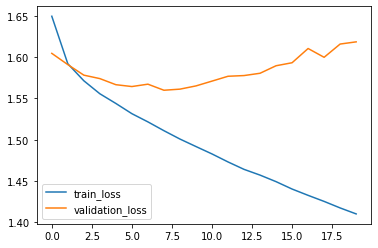

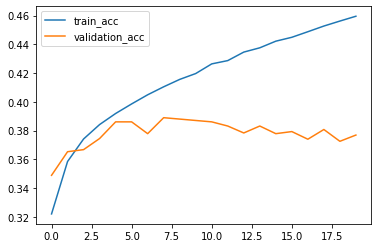

In [48]:
# PLOT HISTORY
plt.plot(hist.history['loss'], label = 'train_loss')
plt.plot(hist.history['val_loss'], label = 'validation_loss')
plt.legend()
plt.show()

plt.plot(hist.history['accuracy'], label = 'train_acc')
plt.plot(hist.history['val_accuracy'], label = 'validation_acc')
plt.legend()
plt.show()

In [49]:
# PRINT THE STATS
avg_train_acc = np.average(hist.history['accuracy'][10:])*100
avg_valid_acc = np.average(hist.history['val_accuracy'][10:])*100
print("Average training acc: ", avg_train_acc)
print("Average validation acc: ", avg_valid_acc)

Average training acc:  44.315026700496674
Average validation acc:  37.92471081018448


In [50]:
# EVALUATE THE MODEL
results = model.evaluate(test_X, test_y)
print("test loss, test acc:", results)

65/65 [==============================] - 0s 2ms/step - loss: 1.6041 - accuracy: 0.3909
test loss, test acc: [1.6041338443756104, 0.39092662930488586]


### Step 12: Predict based on the model and Visualize Output

In [51]:
from sklearn.metrics import confusion_matrix

# VARIABLES USED FOR MODEL SAVING, EVALUATING AND PLOTTING
label2className = get_label2className_dict() # dictionary to map numerical categories to their names : eg {1:"injury", 2:"endocrine"}

In [52]:
# make predictions
test_ypred = model.predict(test_X)
test_ypred = np.argmax(test_ypred, axis=-1)

In [53]:
print(test_ypred.shape)

(2072,)


In [54]:
import itertools  
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
        cm (array, shape = [n, n]): a confusion matrix of integer classes
        class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(10, 10))
    pp = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=0, fontsize=12)
    plt.yticks(tick_marks, class_names, fontsize=12)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, cm[i, j], horizontalalignment="center", color=color, fontsize = 9, weight="bold")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted label', fontsize=14, fontweight='bold') 
    plt.xticks(rotation=45)
    plt.subplots_adjust(bottom=0.1, left=.25)
    return figure

['Cardio-Resp', 'Abdominal', 'Injury/Subst/Poison', 'NeuroPsych', 'Other', 'Obstetric', 'Infection-Immune']


<Figure size 432x288 with 0 Axes>

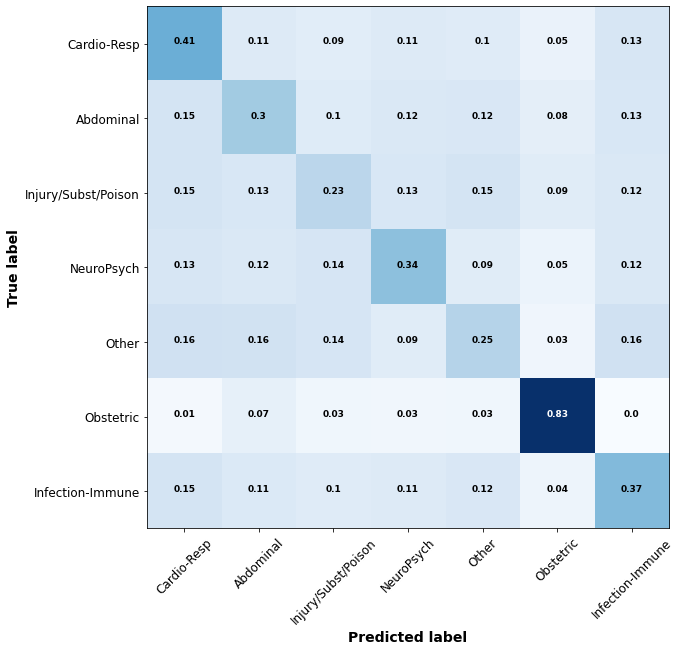

In [55]:
# VISUALIZE PREDICTIVE CAPACITY USING CONFUSION MATRICES
cm = confusion_matrix(np.argmax(test_y, axis=-1), test_ypred)
np.set_printoptions(precision=2)
plt.figure()

class_names = []
for k,v in label2className.items():
    class_names.append(v)
print(class_names)
plot_confusion_matrix(cm, class_names)
plt.savefig('Confusion_matrix_model_{}.png'.format(1))
plt.show()